In [ ]:
import json
import ast
import re
import torch
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

location_path = "./raw/meta-other.json"
review_path = "./raw/review-other.json"
review_classification_path = "./raw/reviews_classified.csv"

In [5]:
def load_location_df(path):
    drop_keys = {"latitude", "longitude", "url"}
    rows = []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            for key in drop_keys:
                obj.pop(key, None)
            rows.append(obj)

    df = pd.DataFrame(rows)
    return df

In [6]:
location_df = load_location_df(location_path)

In [7]:
category_df = location_df.explode("category")
category_counts = category_df["category"].value_counts().reset_index()
category_counts.columns = ["category", "count"]

In [ ]:
print("Unique categories:", category_counts.shape[0])
print("Total category occurrences:", category_counts["count"].sum())

Unique categories: 913
Total category occurrences: 3271


C:\Users\ian\AppData\Local\Temp\ipykernel_34536\2695629035.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_counts.sort_values("count", ascending=False).head(20),


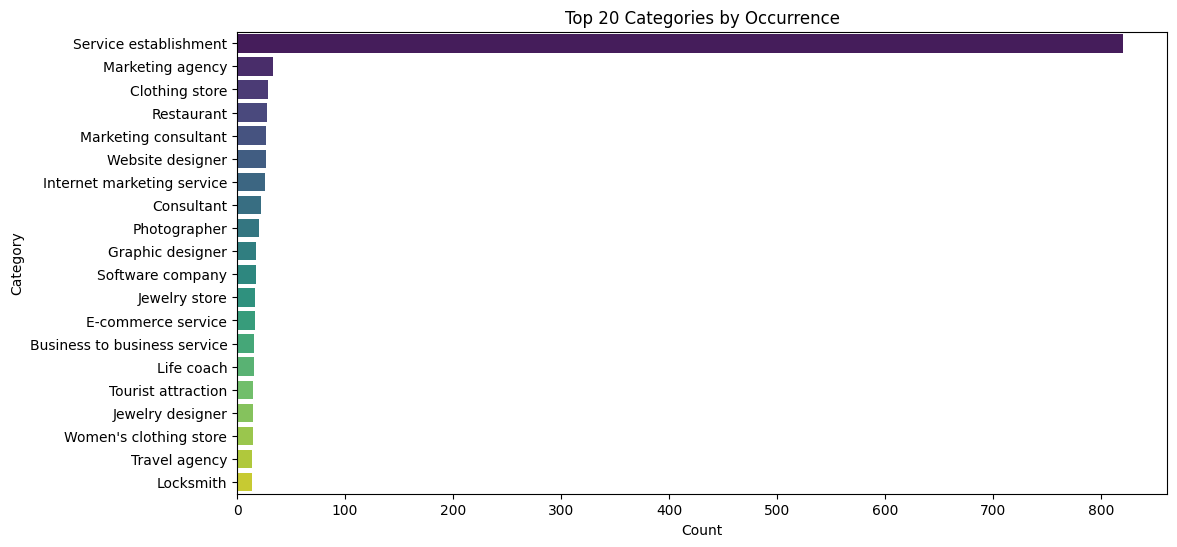

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=category_counts.sort_values("count", ascending=False).head(20),
            x="count", y="category", palette="viridis")
plt.title("Top 20 Categories by Occurrence")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

In [15]:
filtered_categories = category_counts[category_counts["category"] != "Service establishment"]
category_names = filtered_categories["category"].unique()
unique_df = pd.DataFrame({"category": category_names})
unique_df.to_csv("categories.csv", index=False, encoding="utf-8")

In [18]:
def join_csvs(csv_paths, output_path):
    dfs = []
    for path in csv_paths:
        df = pd.read_csv(path, usecols=["Review"])  
        df = df.rename(columns={"Review": "text"})  
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.to_csv(output_path, index=False, encoding="utf-8", quoting=csv.QUOTE_ALL)
    print(f"Saved combined CSV with {len(combined_df)} reviews to {output_path}")

csv_files = [
    r"C:\Users\ian\Downloads\Telegram Desktop\synthetic_reviews_batch2\synthetic_reviews_batch2_part1.csv",
    r"C:\Users\ian\Downloads\Telegram Desktop\synthetic_reviews_batch2\synthetic_reviews_batch2_part2.csv",
    r"C:\Users\ian\Downloads\Telegram Desktop\synthetic_reviews_batch2\synthetic_reviews_batch2_part3.csv",
    r"C:\Users\ian\Downloads\Telegram Desktop\synthetic_reviews_batch2\synthetic_reviews_batch2_part4.csv",
    r"C:\Users\ian\Downloads\Telegram Desktop\synthetic_reviews_batch2\synthetic_reviews_batch2_part5.csv",
    r"C:\Users\ian\Downloads\Telegram Desktop\synthetic_reviews_batch1\synthetic_reviews_part2.csv",
    r"C:\Users\ian\Downloads\Telegram Desktop\synthetic_reviews_batch1\synthetic_reviews_part3.csv",
    r"C:\Users\ian\Downloads\Telegram Desktop\synthetic_reviews_batch1\synthetic_reviews_part4.csv",
    r"C:\Users\ian\Downloads\Telegram Desktop\synthetic_reviews_batch1\synthetic_reviews_part5.csv",
    r"C:\Users\ian\Downloads\Telegram Desktop\synthetic_reviews_batch1\synthetic_reviews_part1.csv",
]

join_csvs(csv_files, r"C:\Users\ian\Desktop\Coding\ReviewClassification\model\data\raw\ads_reviews.csv")


Saved combined CSV with 10000 reviews to C:\Users\ian\Desktop\Coding\ReviewClassification\model\data\raw\ads_reviews.csv


In [21]:
json_path = r"C:\Users\ian\Desktop\Coding\ReviewClassification\model\data\raw\meta-other.json"
output_csv = r"C:\Users\ian\Desktop\Coding\ReviewClassification\model\data\raw\locations.csv"

records = []
with open(json_path, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip(): 
            obj = json.loads(line)
            records.append(obj)

df = pd.DataFrame(records)
columns_to_drop = ["url", "relative_results", "longitude", "latitude"]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
df.to_csv(output_csv, index=False, encoding="utf-8", quoting=csv.QUOTE_ALL)
print(f"Saved CSV with {len(df)} rows to {output_csv}")

Saved CSV with 1224 rows to C:\Users\ian\Desktop\Coding\ReviewClassification\model\data\raw\locations.csv


In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [2]:
from models import NomicEmbedder
import torch
import pandas as pd
device = "cuda:0" if torch.cuda.is_available() else "cpu"

embedder = NomicEmbedder()
embedder.to(device)


df = pd.read_csv(r"C:\Users\ian\Desktop\Coding\ReviewClassification\model\data\processed\locations.csv")

texts = df.drop(columns=['gmap_id']).apply(lambda row: str(row.to_dict()), axis=1).tolist()

batch_size = 64  
vectors = []

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    emb = embedder.embed(batch)   
    emb = emb.detach().cpu().numpy()
    vectors.extend(emb.tolist())

out = pd.DataFrame({
    "gmap_id": df["gmap_id"].tolist(),
    "vector": vectors
})

out.to_pickle("vectorised_locations.pkl")

<All keys matched successfully>


In [4]:
out = pd.read_pickle(r"C:\Users\ian\Desktop\Coding\ReviewClassification\model\data\processed\vectorised_locations.pkl")

print("Number of rows:", len(out))
print("Missing values per column:")
print(out.isna().sum())
vector_lengths = out['vector'].apply(lambda x: len(x))
print("Unique vector lengths:", vector_lengths.unique())

assert out['gmap_id'].notna().all(), "Some gmap_id are missing!"
assert out['vector'].notna().all(), "Some vectors are missing!"
assert len(vector_lengths.unique()) == 1, "Vectors have inconsistent dimensions!"

print("All checks passed!")


Number of rows: 1224
Missing values per column:
gmap_id    0
vector     0
dtype: int64
Unique vector lengths: [768]
All checks passed!
